<a href="https://colab.research.google.com/github/azfarkhoja305/GANs/blob/transformer_generator/Transformer_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [354]:
import os
import sys
from pathlib import Path
import functools 
import math
import pdb

Path.ls = lambda x: list(x.iterdir())

In [355]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchsummary import summary

In [ ]:
!git clone -b transformer_generator https://github.com/azfarkhoja305/GANs.git

In [358]:
if Path('./GANs').exists():
    sys.path.insert(0,'./GANs')

In [359]:
from utils.utils import check_gpu
from utils.trunc_normal import trunc_normal_
from utils.layers import DropPath, gelu, LinearReshape, Block, PixelUpsample, To_RGB, Attention, MLP 

## Attention Mask


In [365]:
# Plot functions
def plot_mask(pixel,mask, ax = None):
    size = int(math.sqrt(len(mask)))
    div = 2 if size <= 12 else 4
    mask[pixel,pixel]=0.5
    img = mask[pixel].view(size,size)
    # if size <=16:   print(img.numpy())
    if ax is None:
        plt.figure(figsize=(size/div,size/div))
        plt.imshow(img, cmap='gray')
        plt.xticks(range(len(img)))
        plt.yticks(range(len(img)))
    else:
        ax.imshow(img, cmap='gray')

def plot_all(pixel_index, w, img_size):
    _, axs = plt.subplots(1,2, figsize=(12,8))
    mask = get_attn_mask(img_size**2,w).squeeze()
    axs[0].imshow(mask, cmap='gray')
    plot_mask(pixel_index,mask,axs[1])

In [366]:
# TODO: Is this the one in the paper? 
# Doesn't seem so
def get_attn_mask(N, w):
    mask = torch.zeros(1, 1, N, N)
    for i in range(N):
        if i <= w:
            mask[:, :, i, 0:i+w+1] = 1
        elif N - i <= w:
            mask[:, :, i, i-w:N] = 1
        else:
            mask[:, :, i, i:i+w+1] = 1
            mask[:, :, i, i-w:i] = 1
    return mask

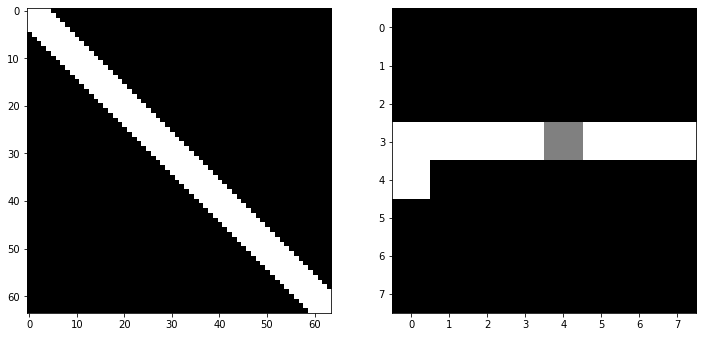

In [367]:
pixel_index = 28
w = 4
img_size=8

plot_all(pixel_index,w,img_size)

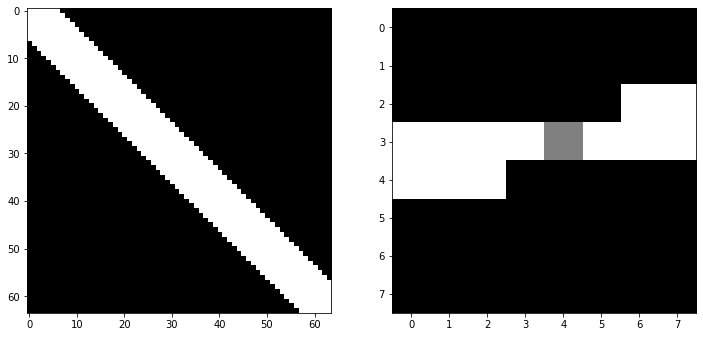

In [368]:
pixel_index = 28
w = 6
img_size=8

plot_all(pixel_index,w,img_size)

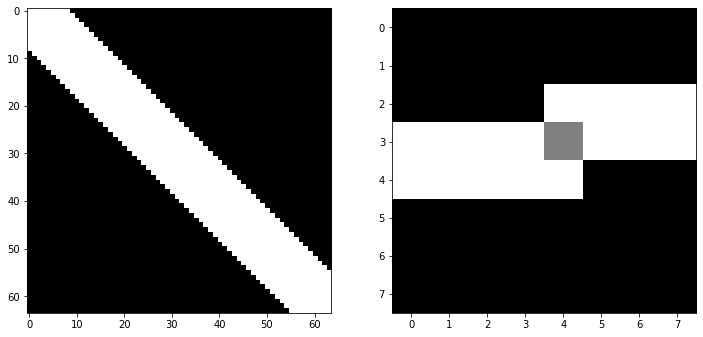

In [369]:
pixel_index = 28
w = 8
img_size=8

plot_all(pixel_index,w,img_size)

## Drop Path

In [370]:
# Copied over from TransGAN/models/ViT_helper.py

def drop_path(x, drop_prob: float = 0., training: bool = False):
    """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).
    This is the same as the DropConnect impl I created for EfficientNet, etc networks, however,
    the original name is misleading as 'Drop Connect' is a different form of dropout in a separate paper...
    See discussion: https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956 ... I've opted for
    changing the layer and argument names to 'drop path' rather than mix DropConnect as a layer name and use
    'survival rate' as the argument.
    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output


class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

In [371]:
#(Batch_sz, num_token, embedding)
samples = torch.ones(2,4,8)
samples

tensor([[[1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.]]])

In [372]:
# Zeros out an entire input sample +
# scales up remaining samples
dp = DropPath(drop_prob=0.5)
dp(samples)

tensor([[[2., 2., 2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2., 2., 2.]],

        [[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.]]])

### Some layers from utils.layers

In [373]:
class Attention(nn.Module):
    def __init__(self, dims, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0,
                 proj_drop=0, attn_mask=False):
        super().__init__()
        self.num_heads = num_heads
        assert dims % num_heads == 0, (f'Dims for Attention: {dims}, not divisible '
            f'by num_heads: {num_heads}')
        head_dims = dims // num_heads
        self.scale = qk_scale or head_dims ** -0.5
        
        self.qkv = nn.Linear(dims, dims*3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dims, dims)
        self.proj_drop = nn.Dropout(proj_drop)
        # TODO:
        if attn_mask:   raise NotImplementedError(f'attn_mask')
        self.attn_mask = attn_mask
    
    def forward(self, x, epoch=None):
        B,N,C = x.shape
        # q,k,v shape: (B, num_heads, N, head_dims)
        q,k,v = self.qkv(x).view(B,N,self.num_heads,-1).permute(0,2,1,3).tensor_split(3, dim=-1)
        # score: (B, num_heads, N, N)
        score = (q @ k.transpose(-2,-1)) * self.scale
        if self.attn_mask: # TODO: Add logic
            score = score.masked_fill(mask==0, -1e9)
        score = self.attn_drop(score.softmax(dim=-1))
        # context: (B, N, C)
        context = (score @ v).permute(0,2,1,3).reshape(B,N,C)
        context = self.proj_drop(self.proj(context))
        return context

In [374]:
# (Batch_sz, num_token, embedding)
samples = torch.rand(16,32,100)
attention = Attention(100,5)
out = attention(samples)
out.shape

torch.Size([16, 32, 100])

In [375]:
class Block(nn.Module):
    def __init__(self, dims, num_heads, mlp_ratio=4, qkv_bias=False, qk_scale=None, mlp_drop=0, attn_drop=False,
                 drop_path=0, att_mask=False, act_layer=gelu, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm_1 = norm_layer(dims)
        self.attention = Attention(dims, num_heads, qkv_bias, qk_scale, attn_drop, 
                                   mlp_drop, att_mask)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm_2 = norm_layer(dims)
        mlp_hidden_dim = int(dims*mlp_ratio)
        self.mlp = MLP(in_feat=dims, hidden_feat=mlp_hidden_dim, act_layer=act_layer, 
                       drop=mlp_drop)

    def forward(self,x,epoch=None):
        x = x + self.drop_path(self.attention(self.norm_1(x), epoch))
        x = x + self.drop_path(self.mlp(self.norm_2(x)))
        return x  

In [376]:
# (Batch_sz, num_token, embedding)
samples = torch.rand(16,32,100)
blk = Block(100,5)
out = blk(samples)
out.shape

torch.Size([16, 32, 100])

In [378]:
class PixelUpsample(nn.Module):
    def __init__(self, start_width):
        super().__init__()
        self.width = start_width
        self.pixelshuffle = nn.PixelShuffle(upscale_factor=2)
    def forward(self, x):
        B,N,C = x.size()
        assert N == self.width**2
        x = x.permute(0,2,1).view(B, C, self.width, self.width)
        x = self.pixelshuffle(x)
        B, C, H, W = x.size()
        x = x.view(B,C,H*W).permute(0,2,1)
        return x

In [379]:
# (Batch_sz, num_pixels, embed_channels)
samples = torch.rand(16,64,400)
pixel_upsample = PixelUpsample(8)
out = pixel_upsample(samples)
out.shape

torch.Size([16, 256, 100])

## Transformer **Generator**

In [380]:
class TGenerator(nn.Module):
    def __init__(self, latent_dims=1024, img_size=32, bottom_width=8, embed_chs=384, depth=[5,2,2],
                 drop_path_rate=0, num_heads=4, mlp_ratio=4, qkv_bias=False, qk_scale=None,  
                 mlp_drop=0, attn_drop=0, att_mask=False, act_layer=gelu, norm_layer=nn.LayerNorm):
        super().__init__()
        assert isinstance(depth, list) and len(depth) == 3

        self.in_layer = LinearReshape(in_dims=latent_dims, out_dims=embed_chs*bottom_width**2, 
                                      width=bottom_width, embed_chs=embed_chs)
        self.pos_embed = nn.ParameterList([
                          nn.Parameter(torch.zeros(1, bottom_width**2, embed_chs)),
                          nn.Parameter(torch.zeros(1, (bottom_width*2)**2, embed_chs//4)),
                          nn.Parameter(torch.zeros(1, (bottom_width*4)**2, embed_chs//16))
        ])
        for emb in self.pos_embed:
            trunc_normal_(emb, std=.02)

        Partial_Block = functools.partial(Block, num_heads=num_heads, mlp_ratio=mlp_ratio, 
                            qkv_bias=qkv_bias, qk_scale=qk_scale, mlp_drop=mlp_drop, attn_drop=attn_drop, 
                            att_mask=att_mask, act_layer=act_layer, norm_layer=norm_layer)
        # stochastic depth decay rule
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth[0])]  
        self.bottom_block = nn.ModuleList([ 
                    Partial_Block(dims=embed_chs, drop_path=dpr[i]) for i in range(depth[0]) 
        ])
        self.upsample_block = nn.ModuleList([
                    nn.ModuleList([Partial_Block(dims=embed_chs//4, drop_path=0)] * depth[1]),
                    nn.ModuleList([Partial_Block(dims=embed_chs//16, drop_path=0)] * depth[2])       
        ])

        self.pixel_upsample = nn.ModuleList([
                                PixelUpsample(start_width=bottom_width),
                                PixelUpsample(start_width=bottom_width*2)
        ])
        
        self.to_rgb = To_RGB(ch_dims=embed_chs//16, img_size=img_size)

    def forward(self, x, epoch=None):
        x = self.in_layer(x) + self.pos_embed[0]
        for blk in self.bottom_block:
            x = blk(x,epoch)
        for i, blocks in enumerate(self.upsample_block):
            x = self.pixel_upsample[i](x) + self.pos_embed[i+1]
            for blk in blocks:
                x = blk(x,epoch)
        x = self.to_rgb(x)
        return x.contiguous()

In [381]:
device = check_gpu()
Gen = TGenerator().to(device)

In [382]:
# (Batch_sz,latent_dims)
noise = torch.randn(16,1024).to(device)
out = Gen(noise)
out.shape

torch.Size([16, 3, 32, 32])

In [383]:
# Expected range [-1,1]
out.min().item(), out.max().item()

(-0.9689114093780518, 0.9828618168830872)

In [384]:
summary(Gen,(1024,),)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 24576]      25,165,824
     LinearReshape-2              [-1, 64, 384]               0
         LayerNorm-3              [-1, 64, 384]             768
            Linear-4             [-1, 64, 1152]         442,368
           Dropout-5            [-1, 4, 64, 64]               0
            Linear-6              [-1, 64, 384]         147,840
           Dropout-7              [-1, 64, 384]               0
         Attention-8              [-1, 64, 384]               0
          Identity-9              [-1, 64, 384]               0
        LayerNorm-10              [-1, 64, 384]             768
           Linear-11             [-1, 64, 1536]         591,360
          Dropout-12             [-1, 64, 1536]               0
           Linear-13              [-1, 64, 384]         590,208
          Dropout-14              [-1, 